<a href="https://colab.research.google.com/github/MadesLaurence/OpenClassrooms-Fruits-Project-8-/blob/main/P8_04_notebook_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
Set-up a first big data architecture using AWS products (Mobile application with a fruit pictures classifier engine)

# Data
Link to upload data: https://www.kaggle.com/moltean/fruits

# Table of contents <a class="anchor" id="chapter0"></a> 
* [Imports and declarations](#chapter1)
    * [Import packages](#sub1_1)
    * [Declare constants](#sub1_2)
* [Exploration of the full dataset](#chapter2)
    * [Get picture information from local full dataset](#sub2_1)
    * [Explore picture information](#sub2_2)
    * [Get class information](#sub2_3) 
    * [Target label encoding](#sub2_4)
* [Preparation of the local sampled picture set](#chapter3)
    * [Create a local sampled picture set](#sub3_1)
    * [Get picture information from local sampled picture set](#sub3_2)
* [Create and configure a Spark Session](#chapter4)
* [Load data](#chapter5)
    * [Load pictures](#sub5_1)
    * [Distinguish Target and Dataset](#sub5_2)
    * [Index Target](#sub5_3)
* [Instantiate a ResNet50 model with pre-trained weights](#chapter6)
* [Features extraction](#chapter7)
    * [Functions](#sub7_1)
    * [Features extraction](#sub7_2)
    * [Features reduction(#sub7_3)
* [Train a new model using pre-computed features](#chapter8)
    * [Prepare my new model](#sub8_1)
    * [Train my new model on Training dataset](#sub8_2)
    * [Predict fruit class with my new model on Test dataset](#sub8_3)
* [Visualise classification results](#chapter9)
* [Go to End](#chapter100)


# Imports and declarations <a class="anchor" id="chapter1"></a>

## Import packages <a class="anchor" id="sub1_1"></a>

In [ ]:
pip install pyspark

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 62.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=c25b0381730ec5a3ea20dbbacdf293edfa01e30b6bd4141cd2b5e80caa6d5632
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
#import P8_02_module as MyMod

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from typing import Iterator
import os
from os import path
import glob
import shutil
import time
import io

import PIL
from PIL import Image

# Pyspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import IntegerType, ArrayType, FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT
print("PySpark version:{}".format(pyspark.__version__)) # Verify PySpark version

# Tensorflow, Keras
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from google.colab import drive
drive.mount('/content/drive')

PySpark version:3.2.1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Declare constants <a class="anchor" id="sub1_2"></a>

In [ ]:
# Sample limitations
GET_PICTURES_NB_PER_CLASS = 2

# Local repositories
LOCAL_SRC_PATH = '../fruits-360-original-size/'
LOCAL_DEST_PATH = 'C:/fruits-360-sample/'
GOOGLE_DEST_PATH = 'drive/MyDrive/fruits-360-sample/'

# Image size
IMAGE_RESIZE = 224

# S3 Bucket
BUCKET_NAME = "moncompartimentamoi"

# Exploration of the full dataset <a class="anchor" id="chapter2"></a>

## Get picture information from local full dataset <a class="anchor" id="sub2_1"></a>

In [ ]:
def rep_2_picture_info(path):

    # Initiate Dataframe with Dataset names, Target class names and Picture names
    df = pd.DataFrame(columns = ['FullFileName', 'Dataset', 'Target', 'Picture', 'FileSize (in KB)']) 

    for file in glob.iglob(path+'**/*.jpg', recursive = True):

        lst = file.split('\\')
        
        # update DataFrame
        lst.append(os.path.getsize(file) / 1024)  # in KBytes    
        lst[0] = lst[0] + "/" + lst[1] + "/" + lst[2] + "/" + lst[3]
        df.loc[len(df)] = lst

    return df

In [ ]:
df_main = rep_2_picture_info(LOCAL_SRC_PATH)
df_main

,FullFileName,Dataset,Target,Picture,FileSize (in KB)


## Explore picture information <a class="anchor" id="sub2_2"></a>

### Assess volumes and modalities

In [ ]:
df_main.describe()

,FullFileName,Dataset,Target,Picture,FileSize (in KB)
count,0,0,0,0,0
unique,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN


 > 12 455 pictures, 24 target classes, 3 datasets  
 > 958 picture names mean that some pictures have the same name and are not classified in the same repository

### Count pictures by target class and dataset

In [ ]:
pd.DataFrame(df_main.groupby(['Target', 'Dataset'])['Picture'].count())

,,Picture
Target,Dataset,


### Count pictures by target class

In [ ]:
pd.DataFrame(df_main.groupby(['Target'])['Picture'].count())

,Picture
Target,


### Count dataset modality by picture name

In [ ]:
df_dataset_mod = pd.DataFrame(df_main.groupby(['Picture'])['Dataset'].nunique())
df_dataset_mod.rename(columns={'Dataset':'Dataset_mod'}, inplace=True)
len(df_dataset_mod[df_dataset_mod['Dataset_mod'] > 1])

0

> No file with the same name in the different datasets

### Count target class modality by picture name

In [ ]:
df_target_mod = pd.DataFrame(df_main.groupby(['Picture'])['Target'].nunique())
df_target_mod.rename(columns={'Target':'Target_mod'}, inplace=True)
df_target_mod[df_target_mod['Target_mod'] > 1]

,Target_mod
Picture,


In [ ]:
df_target_mod = df_target_mod.reset_index(drop=False)

In [ ]:
pd.DataFrame(df_target_mod.groupby(['Target_mod'])['Picture'].count())

,Picture
Target_mod,


 > many files with the same name in the different target classes   
 > for instance, 156 files have the same name and appear in 24 different target class

In [ ]:
df_main[df_main['Picture'] == 'r0_0.jpg'][['Picture', 'Target', 'Dataset']]

,Picture,Target,Dataset


In [ ]:
pict = Image.open(df_main['FullFileName'].iloc[20])
plt.imshow(pict)
plt.show()

"pict = Image.open(df_main['FullFileName'].iloc[20])\nplt.imshow(pict)\nplt.show()"

In [ ]:
pict = Image.open(df_main['FullFileName'].iloc[40])
plt.imshow(pict)
plt.show()

"pict = Image.open(df_main['FullFileName'].iloc[40])\nplt.imshow(pict)\nplt.show()"

 > File name format: r?_image_index.jpg (e.g. r0_31.jpg or r1_12.jpg)  
 > "r?" stands for rotation axis (first one is r0)

### Distinguish rotation axis and index

In [ ]:
# Laurence: supprimer les FutureWarning
df_main["Rotation"], df_main["Index"] = df_main["Picture"].str.split("_", 1).str
df_main["Rotation"] = df_main["Rotation"].str.replace('r','')
df_main["Index"] = df_main["Index"].str.replace('.jpg','')
df_main

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


ValueError: ignored

In [ ]:
pd.DataFrame(df_main["Rotation"].unique())

In [ ]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '0'].head(1).index[0]])
plt.imshow(pict)
plt.show()

In [ ]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '1'].head(1).index[0]])
plt.imshow(pict)
plt.show()

In [ ]:
pict = Image.open(df_main['FullFileName'].iloc[df_main[df_main['Rotation'] == '2'].head(1).index[0]])
plt.imshow(pict)
plt.show()

 > 0 - queue top or down > rotation around the z-axis  
 > 1 - queue behind or ahead > rotation around the x-axis  
 > 2 - queue left or right > rotation around the y-axis  

### Target class count distribution

In [ ]:
def distribution(df_in, dataset):
    
    df = df_in.copy()
    
    if dataset in ['Training', 'Test', 'Validation']:
        df.drop(df[df['Dataset'] != dataset].index, inplace=True)
    elif dataset != '*':
        print("dataset argument should be 'Training', 'Test', 'Validation' or '*'")
        return -1
        
    df_distrib = pd.DataFrame(df.groupby(['Target'])['Picture'].count())
    df_distrib.reset_index(drop=False, inplace=True)
    df_distrib.rename(columns={'Picture':'Picture count', 'Target':'Class'}, inplace=True)
    df_distrib = df_distrib.sort_values(by='Class', ascending=False)    

    if len(df_distrib) == 0: return -1
    
    df_distrib.plot.barh(x='Class', y='Picture count', figsize=(12, 10))    
    
    return 1

In [ ]:
ret = distribution(df_main, 'Training')
ret = distribution(df_main, 'Test')
ret = distribution(df_main, 'Validation')
ret = distribution(df_main, '*')

### Target class filesize average distribution  
Logitech C920 camera and dedicated algorithm which extract the fruit from the background

In [ ]:
pd.DataFrame(df_main.groupby('Target')['FileSize (in KB)'].mean())

In [ ]:
pd.DataFrame(df_main.groupby('Dataset')['FileSize (in KB)'].mean())

In [ ]:
df_main['FileSize (in KB)'].mean(), df_main['FileSize (in KB)'].sum()/1024**2

## Get class information <a class="anchor" id="sub2_3"></a>

In [ ]:
path = '../fruits-360-original-size/Meta/'

df_class_add = pd.DataFrame(columns = ['PathName', 'Target', 'TxtName'])
df_meta = pd.DataFrame(columns = ['Flag', 'Value'])

for file in glob.iglob(path+'**/info.txt', recursive = True):
    
    df_meta_add = pd.read_csv(file, sep="=", names=['Flag', 'Value'])
        
    df_class_add.loc[0] = file.split('\\')   
        
    df_meta = pd.concat([df_class_add.join(df_meta_add, how='cross'), df_meta])

del df_class_add, df_meta_add

df_meta.drop(columns=['PathName', 'TxtName'], inplace=True)
df_meta = df_meta.sort_values(['Target', 'Flag'], ascending=True)
df_meta.reset_index(drop=True, inplace=True)
df_meta

In [ ]:
df_meta['Flag'].nunique()

In [ ]:
pd.DataFrame(df_meta['Flag'].unique(), columns=['Flag']).sort_values(by='Flag')

## Target label encoding  <a class="anchor" id="sub2_4"></a>

In [ ]:
df_main, df_target_mapping = MyMod.encode_LabelEncoder(df_main, 'Target')
df_main.head(5)

In [ ]:
df_meta, df_target_mapping = MyMod.encode_LabelEncoder(df_meta, 'Target')
df_meta.head(5)

In [ ]:
df_target_mapping

# Preparation of the local sampled picture set <a class="anchor" id="chapter3"></a>

## Create a local sampled picture set <a class="anchor" id="sub3_1"></a>

In [ ]:
target_prec = ""
for file in glob.iglob(LOCAL_SRC_PATH+'**/*.jpg', recursive = True):
    
    lst = file.split('\\')
    
    # Limit number of pictures per class(GET_PICTURES_NB_PER_CLASS)
    if lst[2] == target_prec: 
        i += 1
    else:
        i = 0
    target_prec = lst[2]
    
    if (lst[1] == 'Training' and i < 2*GET_PICTURES_NB_PER_CLASS) or \
                    (lst[1] != 'Training' and i < GET_PICTURES_NB_PER_CLASS):     
                
        # create the destination repository if necessary
        if not os.path.exists(LOCAL_DEST_PATH+lst[1]+"/"+lst[2]):
             os.makedirs(LOCAL_DEST_PATH+lst[1]+"/"+lst[2])

        # copy the file to the destination repository
        shutil.copyfile(LOCAL_SRC_PATH+lst[1]+"/"+lst[2]+"/"+lst[3], LOCAL_DEST_PATH+lst[1]+"/"+lst[2]+"/"+lst[3])

## Get picture information from local sampled picture set <a class="anchor" id="sub3_2"></a>

In [ ]:
df_main = rep_2_picture_info(GOOGLE_DEST_PATH)
df_main

# Create and configure a Spark Session <a class="anchor" id="chapter4"></a> 
- builder()     generator to create the session
- master()      master name (yarn, mesos or local[number of cores to use]. Number of partitions for distributed objects.
- appName()     name the application
- getOrCreate() create a new session or return the existing one
- config()      configure session
    - spark.sql.repl.eagerEval.enabled: PySpark DataFrame quick assessment in Jupyter  
    - spark.sql.repl.eagerEval.maxNumRows: number of lines to show      
    - spark.sql.execution.arrow.pyspark.enabled: to use Arrow optimiser for Spark to Pandas DataFrame conversions (toPandas or createDataFrame)  

In [ ]:
# Instantiate SparkSession
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('P8_03')\
        .getOrCreate()

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)

#spark.conf.set('java.io.tmpdir', 'C:\Users\Public\AppData\Local\Temp\')
#java.library.path

# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [ ]:
# Get the SparkContext
sc = spark.sparkContext

In [ ]:
# User web interface
spark

# Load data <a class="anchor" id="chapter5"></a> 

## Load pictures <a class="anchor" id="sub5_1"></a> 

### Get pictures in a Spark DataFrame in "image" format

In [ ]:
pictures_df = spark.read.format('image').load(GOOGLE_DEST_PATH+"*/*/*.jpg", inferschema=True)
pictures_df.count()

193

In [ ]:
pictures_df.select('image.origin').show(5, False, True)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
# Spark DataFrame scheme
pictures_df.printSchema()

### Get pictures in a Spark DataFrame in "binaryFile" format

In [ ]:
pictures_df = spark.read.format("binaryFile") \
            .option("pathGlobFilter", "*.jpg") \
            .option("recursiveFileLookup", "true") \
            .load(GOOGLE_DEST_PATH+"*/*/*.jpg")

In [ ]:
# Count sample size
pictures_df.count()

193

In [ ]:
# Spark DataFrame visualisation
pictures_df.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/dri...|2022-03-21 14:12:59|123514|[FF D8 FF E0 00 1...|
|file:/content/dri...|2022-03-21 14:13:00|122525|[FF D8 FF E0 00 1...|
|file:/content/dri...|2022-03-21 14:12:59|121530|[FF D8 FF E0 00 1...|
|file:/content/dri...|2022-03-21 14:13:00|119805|[FF D8 FF E0 00 1...|
|file:/content/dri...|2022-03-21 14:13:00|119068|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



In [ ]:
# Spark DataFrame scheme
pictures_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



## Distinguish Target and DataSet <a class="anchor" id="sub5_2"></a> 

In [ ]:
# Extract Target from path
pictures_df = pictures_df.withColumn('target', element_at(split(pictures_df['path'], "/"), -2))

In [ ]:
# Extract DataSet from path
pictures_df = pictures_df.withColumn('dataset', element_at(split(pictures_df['path'], "/"), -3))

## Index Target <a class="anchor" id="sub5_3"></a> 

In [ ]:
indexer = StringIndexer(inputCol="target", outputCol="target_code") 
pictures_df = indexer.fit(pictures_df).transform(pictures_df)
pictures_df.show(20)

+--------------------+-------------------+------+--------------------+---------------+----------+-----------+
|                path|   modificationTime|length|             content|         target|   dataset|target_code|
+--------------------+-------------------+------+--------------------+---------------+----------+-----------+
|file:/content/dri...|2022-03-21 14:12:59|123514|[FF D8 FF E0 00 1...|    apple_hit_1|      Test|        7.0|
|file:/content/dri...|2022-03-21 14:13:00|122525|[FF D8 FF E0 00 1...|    apple_hit_1|  Training|        7.0|
|file:/content/dri...|2022-03-21 14:12:59|121530|[FF D8 FF E0 00 1...|    apple_hit_1|      Test|        7.0|
|file:/content/dri...|2022-03-21 14:13:00|119805|[FF D8 FF E0 00 1...|    apple_hit_1|Validation|        7.0|
|file:/content/dri...|2022-03-21 14:13:00|119068|[FF D8 FF E0 00 1...|    apple_hit_1|  Training|        7.0|
|file:/content/dri...|2022-03-21 14:13:01| 96730|[FF D8 FF E0 00 1...|cabbage_white_1|Validation|       15.0|
|file:/con

In [ ]:
pictures_df = pictures_df.withColumn("target_code",pictures_df.target_code.cast(IntegerType()))
pictures_df.show(20)

+--------------------+-------------------+------+--------------------+---------------+----------+-----------+
|                path|   modificationTime|length|             content|         target|   dataset|target_code|
+--------------------+-------------------+------+--------------------+---------------+----------+-----------+
|file:/content/dri...|2022-03-21 14:12:59|123514|[FF D8 FF E0 00 1...|    apple_hit_1|      Test|          7|
|file:/content/dri...|2022-03-21 14:13:00|122525|[FF D8 FF E0 00 1...|    apple_hit_1|  Training|          7|
|file:/content/dri...|2022-03-21 14:12:59|121530|[FF D8 FF E0 00 1...|    apple_hit_1|      Test|          7|
|file:/content/dri...|2022-03-21 14:13:00|119805|[FF D8 FF E0 00 1...|    apple_hit_1|Validation|          7|
|file:/content/dri...|2022-03-21 14:13:00|119068|[FF D8 FF E0 00 1...|    apple_hit_1|  Training|          7|
|file:/content/dri...|2022-03-21 14:13:01| 96730|[FF D8 FF E0 00 1...|cabbage_white_1|Validation|         15|
|file:/con

In [ ]:
# Spark DataFrame scheme
pictures_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- target: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- target_code: integer (nullable = true)



# Instantiate a ResNet50 model with pre-trained weights  <a class="anchor" id="chapter6"></a> 
"Residual Network" with 50 layers. Convolutional Neural Network

In [ ]:
pre_model = ResNet50(
    # Weights pre-trained on ImageNet: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 
    # in cache directory (~/.keras/models)
    weights='imagenet',                                 
    input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3),
    # Do not include the ImageNet fully-connected layer at the top of the network
    include_top=True,
    classes=1000)
print(len(pre_model.layers))

102981632/102967424 [==============================] - 1s 0us/step
177


In [ ]:
pre_model.summary()

In [ ]:
pre_model = ResNet50(
    # Weights pre-trained on ImageNet: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 
    # in cache directory (~/.keras/models)
    weights='imagenet',                                 
    input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3),
    # Do not include the ImageNet fully-connected layer at the top of the network
    include_top=False,
    classes=24)
print(len(pre_model.layers))

94781440/94765736 [==============================] - 1s 0us/step
175


In [ ]:
pre_model.summary()

In [ ]:
pre_model.layers[0], pre_model.layers[1], pre_model.layers[19]

(<keras.engine.input_layer.InputLayer at 0x7f7bba757d50>,
 <keras.layers.convolutional.Conv2D at 0x7f7bb5df6f50>)

In [ ]:
# Broadcast the model weights in the SparkContext
bc_model_weights = sc.broadcast(pre_model.get_weights())

# Features extraction <a class="anchor" id="chapter7"></a> 

1 - Instantiate a base model and load pre-trained weights into it  
2 - Run your new dataset through it and record the output of one/several layers from the base model   
3 - Use that output as input data for a new, smaller model   
advantage: you only run the base model once on your data, rather than once per epoch of training > a lot faster & cheaper  
issue: doesn't allow you to dynamically modify the input data of your new model during training, which is required when doing data augmentation  

## Functions  <a class="anchor" id="sub7_1"></a> 
https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [ ]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    
    model = ResNet50(
        weights=None,                                 
        input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3),
        include_top=False,         # Do not include the ImageNet fully-connected layer at the top of the network
        classes=24)

    # set model weights to previously broadcasted weights
    model.set_weights(bc_model_weights.value)
    
    return model

### Preprocess one image

In [ ]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    # Redimension of the picture
    img = Image.open(io.BytesIO(content)).resize([IMAGE_RESIZE, IMAGE_RESIZE])
    
    # Converts the PIL Image instance to a Numpy array
    arr = img_to_array(img)
    
    # Preprocesses a tensor or Numpy array encoding a batch of images
    return preprocess_input(arr)

### Featurize a pd.Series of images

In [ ]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    # Join the sequence of arrays along the first axis. The stacked array has one more dimension than the input arrays
    input = np.stack(content_series.map(preprocess))
    
    # Compute predictions 
    preds = model.predict(input)

    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    
    return pd.Series(output)

###  Featurize all images
PandasUDFType.SCALAR_ITER used to amortize the cost of loading large models on workers  

PandasUDF User Defined Function  
New Pandas UDFs with Python type hints  

In [ ]:
@pandas_udf('array<float>')
def featurize_udf(content_series_iter: Iterator[pd.Series]) -> Iterator[pd.Series]:
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches. This amortizes the overhead of loading big models.    
    pre_model = model_fn()
    
    for content_series in content_series_iter:
        
        # Yield returns a generator to the caller and the execution of the code starts only when the generator is iterated 
        yield featurize_series(pre_model, content_series)

## Features extraction  <a class="anchor" id="sub7_2"></a> 

In [ ]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [ ]:
# Save starting time
time_start = time.time()

# Large model to the full dataset
BATCH_SIZE = 16 # Dispatches dataframe over 16 partitions
features_df = pictures_df.repartition(BATCH_SIZE).select(col("dataset"), col('target'), col('target_code'), col("content"), featurize_udf("content").alias("X_features"))

# Compute time elapse
elapse_s = time.time()-time_start
elapse_m = int(elapse_s / 60)
print('Feature extraction done! Time elapsed: {} seconds ({} minutes)'.format(elapse_s, elapse_m))

Feature extraction done! Time elapsed: 0.10957050323486328 seconds (0 minutes)


In [ ]:
features_df.persist()

dataset,target,target_code,content,X_features
Test,pear_3,21,[FF D8 FF E0 00 1...,"[0.0, 0.0, 0.0, 0..."
Training,cucumber_3,18,[FF D8 FF E0 00 1...,"[2.2741177, 0.0, ..."
Training,apple_red_3,11,[FF D8 FF E0 00 1...,"[0.0, 0.0, 0.0, 0..."
Training,apple_crimson_snow_1,2,[FF D8 FF E0 00 1...,"[0.0, 0.0, 0.0, 0..."
Training,apple_red_delicios_1,12,[FF D8 FF E0 00 1...,"[0.0, 0.0, 0.0, 0..."


In [ ]:
features_df.show()

+----------+--------------------+-----------+--------------------+--------------------+
|   dataset|              target|target_code|             content|          X_features|
+----------+--------------------+-----------+--------------------+--------------------+
|      Test|              pear_3|         21|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|
|  Training|          cucumber_3|         18|[FF D8 FF E0 00 1...|[2.2741177, 0.0, ...|
|  Training|         apple_red_3|         11|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|
|  Training|apple_crimson_snow_1|          2|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|
|  Training|apple_red_delicios_1|         12|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|
|  Training|         apple_red_2|         10|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|
|Validation|      apple_golden_1|          3|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|
|  Training|          zucchini_1|         22|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|
|  Training|      apple_golden_2

In [ ]:
picture_cnt = features_df.count()
avg_elapse_s = elapse_s / picture_cnt

print('Number of pictures: {}'.format(picture_cnt))
print('Average time elapsed per picture: {} seconds'.format(avg_elapse_s))

Number of pictures: 193
Average time elapsed per picture: 0.0005677228146884108 seconds


## Features reduction  <a class="anchor" id="sub7_3"></a> 

In [ ]:
def pca_transformation(df, n_components=10):
    
    """
    Applique un algorithme de PCA sur l'ensemble des images pour réduire la dimension de chaque image 
    du jeu de données.
    
    Paramètres:
    df(pyspark dataFrame): contient une colonne avec les données images
    n_components(int): nombre de dimensions à conserver
    """
    # Initilisation du temps de calcul
    start_time = time.time()

    # Les données images sont converties au format vecteur dense
    to_vector_udf = udf(lambda r: Vectors.dense(r), VectorUDT())
    df = df.withColumn('X_vectors', to_vector_udf('X_features'))

    # Entrainement de l'algorithme
    pca = PCA(k=n_components, inputCol='X_vectors', outputCol='X_vectors_pca')
    model_pca = pca.fit(df)

    # Transformation des images sur les k premières composantes
    df = model_pca.transform(df)
    
    # Affiche le temps de calcul
    print("Temps d'execution {:.2f} secondes".format(time.time() - start_time))

    return df

Temps d'execution 1816.13 secondes


In [ ]:
final_df = pca_transformation(features_df)

In [ ]:
final_df.show()

+----------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|   dataset|              target|target_code|             content|          X_features|           X_vectors|       X_vectors_pca|
+----------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|      Test|              pear_3|         21|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[-87.598921875144...|
|  Training|          cucumber_3|         18|[FF D8 FF E0 00 1...|[2.2741177, 0.0, ...|[2.27411770820617...|[143.200677678075...|
|  Training|         apple_red_3|         11|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[-122.91375325607...|
|  Training|apple_crimson_snow_1|          2|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[-112.00103849373...|
|  Training|apple_red_delicios_1|         12|[FF D8 FF E0 00 1...|[0.0, 0.0, 0.0, 0...|[0.

In [ ]:
# write spark dataframe to a Parquet file
final_df.write.mode("overwrite").parquet("drive/MyDrive/reduced_features_parquet")

# Train a new model using pre-computed features <a class="anchor" id="chapter8"></a> 

Layers trainable attributes:
- weights : list of all weights variables of the layer  
- trainable_weights : list of those that are meant to be updated (via gradient descent) to minimize the loss during training  
- non_trainable_weights : list of those that aren't meant to be trained (updated by the model during the forward pass)  
- trainable : false moves all the layer's weights from trainable to non-trainable ("freezing" the layer)  
The only built-in layer that has non-trainable weights is the BatchNormalization layer  

1 - Instantiate a base model and load pre-trained weights into it  
2 - Freeze all layers in the base model by setting trainable = False  
3 - Create a new model on top of the output of one/several layers from the base model  
4 - Train your new model on your new dataset  (top layers to learn to turn the old features into predictions on a new dataset)   

Fine-tuning (optionnal): 
unfreeze the entire/partial model you obtained and re-training it on the new data with a very low learning rate  

## Prepare my new model <a class="anchor" id="sub8_1"></a> 

In [ ]:
def add_layers_2_model(pretrained_model):
    """

    """    
    # Freeze all layers in the base model by setting trainable = False
    pretrained_model.trainable = False

    # Create a new model on top of the output of one layer from the model ------------------------------------------- 
    new_model = Sequential()

    new_model.add(pretrained_model)

    new_model.add(Flatten())
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dense(25, activation='softmax'))

    # Compile
    sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
    OBJECTIVE_FUNCTION = 'categorical_crossentropy'
    LOSS_METRICS = ['accuracy']
    new_model.compile(optimizer=sgd, loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)
    
    return new_model

In [ ]:
new_model = add_layers_2_model(pre_model)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               51380736  
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 74,981,273
Trainable params: 51,393,561
Non-trainable params: 23,587,712
_________________________________________________________________


Spark workers need to access the model and its weights.  
For moderately sized models (< 1GB in size), a good practice is to download the model to the Spark driver and 
then broadcast the weights to the workers.  
For large models (> 1GB), it is best to load the model weights from distributed storage to workers directly.  

## Train my new model on Training dataset <a class="anchor" id="sub8_2"></a> 

In [ ]:
def preprocess(content):
    # Redimension of the picture
    img = Image.open(io.BytesIO(content)).resize([IMAGE_RESIZE, IMAGE_RESIZE])
    
    # Converts the PIL Image instance to a Numpy array
    arr = img_to_array(img)
    
    # Preprocesses a Numpy array encoding a batch of images
    # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling
    # data_format=None > "channels_last" assumes the dimension order is (rows, cols, channels)
    arr_temp = preprocess_input(arr, data_format=None)
    
    return arr_temp

    # Return a copy of the array data as a (nested) Python list. Data items are converted to the nearest compatible builtin Python type, via the item function.
    # Convert to a list whose values are Python primitives instead of numpy objects numpy.float32 (mismatched data types between Python and Spark)
    #return arr_temp.tolist()

    #return arr_temp.astype(np.float).tolist()
    #return tf.convert_to_tensor(arr_temp, dtype=tf.float32)
    #return tf.convert_to_tensor(arr_temp.astype(np.float).tolist())

### Train with PySpark Functions (UDF): to be further developped  
https://changhsinlee.com/pyspark-udf/

In [ ]:
preprocess_udf = udf(lambda content_series: preprocess(content_series), ArrayType(FloatType()))

preprocess_df = pictures_df.select('dataset', 'target', 'target_code', preprocess_udf('content').alias("model_input"))
preprocess_df.show()

In [ ]:
preprocess_df.show(1, False, True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
img = Image.open(GOOGLE_DEST_PATH+'Training/apple_6/r0_0.jpg').resize([IMAGE_RESIZE, IMAGE_RESIZE])
type(img)

PIL.Image.Image

In [ ]:
arr = img_to_array(img)
type(arr)

numpy.ndarray

In [ ]:
arr.shape

(224, 224, 3)

In [ ]:
arr

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [ ]:
arr_temp = preprocess_input(arr, data_format=None)
arr_temp.shape

(224, 224, 3)

In [ ]:
arr_temp

array([[[47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        ...,
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007]],

       [[47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        ...,
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007]],

       [[47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        ...,
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007]],

       ...,

       [[47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        [47.122   , 21.442009,  7.640007],
        ...,
        [47.122   , 21.442

In [ ]:
arr_temp.tolist()

### Train with Python Functions

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
df_pictures = pictures_df.toPandas()

# Isolate train dataset
df_train = df_pictures[df_pictures['dataset'] == 'Training']

# Preprocess raw image bytes
X_train = np.stack(df_train['content'].map(preprocess))
print("Shape X_train: ", X_train.shape)

y_train = df_train['target_code'].values

# one-hot encoding using keras' numpy-related utilities
print("Shape y_train before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, 25)
print("Shape Y_train after one-hot encoding: ", Y_train.shape)

Shape X_train:  (97, 224, 224, 3)
Shape y_train before one-hot encoding:  (97,)
Shape Y_train after one-hot encoding:  (97, 25)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# Train new_model with Training dataset
EARLY_STOP_PATIENCE = 10  # EARLY_STOP_PATIENCE must be < NUM_EPOCHS
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = EARLY_STOP_PATIENCE)

cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'loss', save_best_only = True, mode = 'auto')

NUM_EPOCHS = 30
preds = new_model.fit(x=X_train, y=Y_train, epochs=NUM_EPOCHS, callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/10
4/4 [==============================] - 18s 4s/step - loss: 670.0675 - accuracy: 0.0619
Epoch 2/10
4/4 [==============================] - 16s 4s/step - loss: 1093.9584 - accuracy: 0.2474
Epoch 3/10
4/4 [==============================] - 17s 4s/step - loss: 114.9367 - accuracy: 0.3608
Epoch 4/10
4/4 [==============================] - 17s 4s/step - loss: 67.5636 - accuracy: 0.3918
Epoch 5/10
4/4 [==============================] - 17s 4s/step - loss: 2.5487 - accuracy: 0.4536
Epoch 6/10
4/4 [==============================] - 16s 4s/step - loss: 3.3675 - accuracy: 0.4227
Epoch 7/10
4/4 [==============================] - 16s 4s/step - loss: 7.1960 - accuracy: 0.4433
Epoch 8/10
4/4 [==============================] - 16s 4s/step - loss: 3.5551 - accuracy: 0.4536


In [ ]:
new_model.save("drive/MyDrive/fruits-360_transferlearning_restnet50.h5")

## Predict fruit class with my new model on Test dataset <a class="anchor" id="sub8_3"></a> 

In [ ]:
# Isolate test dataset
df_test = df_pictures[df_pictures['dataset'] == 'Test']

# Preprocess raw image bytes
X_test = np.stack(df_test['content'].map(preprocess))
print("Shape X_test: ", X_test.shape)

# Compute target probabilities
Y_test_pred = new_model.predict(X_test)
print("Shape Y_test_pred: ", Y_test_pred.shape)

# Deduct target prediction
y_test_pred = np.argmax(Y_test_pred, axis=1)
print("Shape y_test_pred: ", y_test_pred.shape)

Shape X_test:  (48, 224, 224, 3)
Shape Y_test_pred:  (48, 25)
Shape y_test_pred:  (48,)


# Visualise classification results <a class="anchor" id="chapter9"></a> 

In [ ]:
df_final = final_df.toPandas()

# Isolate Test dataset
df_test = df_final[df_final['dataset'] == 'Test']

# Transform to Array
X_test_pca = np.stack(df_test['X_vectors_pca'])

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


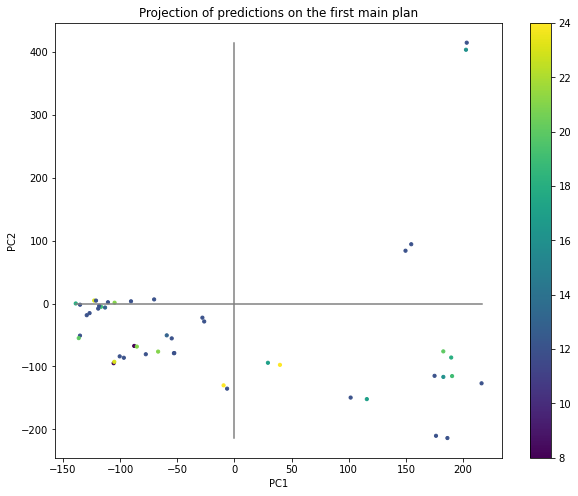

In [ ]:
fig = plt.figure(figsize=(10, 8))

# Draw predictions in the first main plan
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=10, c=y_test_pred+1)
plt.colorbar()

plt.plot([X_test_pca[:, 0].min(), X_test_pca[:, 0].max()], [0, 0], color='grey', ls='-') 
plt.plot([0, 0], [X_test_pca[:, 1].min(), X_test_pca[:, 1].max()], color='grey', ls='-') 

plt.title("Projection of predictions on the first main plan")
plt.xlabel("PC1")
plt.ylabel("PC2")   
   
plt.show()

* [Go to Table des matières](#chapter0)

# End <a class="anchor" id="chapter100"></a> 